In [11]:
import torch
from torch import nn
from typing import List, Tuple, Dict
from torch.nn import functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from skorch import NeuralNet
from skorch.dataset import CVSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np


torch.cuda.is_available()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [ ]:
trainset = MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
testset  = MNIST(root = './data', train = False, download = True, transform = transforms.ToTensor())

batch_size = 100
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)

Teste com um autoencoder normal para ter um parâmetro.

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dim)

    def forward(self, x):
#         x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dim, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
#         return z.reshape((-1, 1, 28, 28))
        return z


class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [298]:
skorch_model = NeuralNet(
    module = Autoencoder,
    module__latent_dim  = 500,
    criterion = nn.MSELoss,
    optimizer = torch.optim.Adam,
    lr = 0.01,
    max_epochs = 100,
    batch_size = 10000,
    iterator_train__shuffle=True,
    train_split = CVSplit(0.33),
    device = device,
    verbose = True
)

scaler = MinMaxScaler()
# scaler = StandardScaler()

A = trainloader.dataset.data.reshape(len(trainset), -1).float().numpy()
scaler.fit(A)
A = scaler.transform(A)

skorch_model.fit(A, A)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1349        0.1134  1.1565
      2        0.0848        0.0730  1.0651
      3        0.0708        0.0649  0.9121
      4        0.0657        0.0612  1.0693
      5        0.0609        0.0595  1.0702
      6        0.0582        0.0563  1.0642
      7        0.0554        0.0533  1.0638
      8        0.0526        0.0504  1.1005
      9        0.0500        0.0480  1.0652
     10        0.0476        0.0461  1.1023
     11        0.0456        0.0447  0.9111
     12        0.0441        0.0429  1.1022
     13        0.0433        0.0426  1.0533
     14        0.0414        0.0402  1.1007
     15        0.0394        0.0383  1.1014
     16        0.0375        0.0358  1.1113
     17        0.0356        0.0344  1.0917
     18        0.0342        0.0334  1.0658
     19        0.0331        0.0333  1.0851
     20        0.0332        0.0319  0.9033
     21        0.0315        0.0

<class 'skorch.net.NeuralNet'>[initialized](
  module_=Autoencoder(
    (encoder): Encoder(
      (linear1): Linear(in_features=784, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=500, bias=True)
    )
    (decoder): Decoder(
      (linear1): Linear(in_features=500, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=784, bias=True)
    )
  ),
)

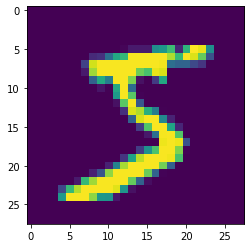

In [299]:
plt.imshow(A[0].reshape(28, 28))

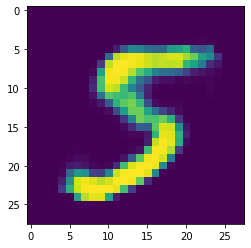

In [300]:
plt.imshow(skorch_model.forward(A[0]).reshape(28, 28))

Autoencoder Variacional

In [35]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim: int = 43, latent_dim: int = 30, hidden_dims: List[int] = [40, 35]) -> None:
        super(VariationalAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        modules = []
        for h_dim in hidden_dims:
            modules.append(nn.Sequential(
                nn.Linear(input_dim, h_dim),
                nn.Dropout(0.1),
                nn.ReLU()
            ))
            input_dim = h_dim
            
        self.Encoder = nn.Sequential(*modules)
        
        self.mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.log_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        self.N = torch.distributions.Normal(0, 1)
        
        modules = []
        modules.append(nn.Linear(latent_dim, hidden_dims[-1]))
        hidden_dims.reverse()
        hidden_dims.append(self.input_dim)
        for i in range(len(hidden_dims) - 1):
            modules.append(nn.Sequential(
                nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                nn.ReLU()
            ))
        self.Decoder = nn.Sequential(*modules)
        
        if device == 'cuda':
            self.N.loc = self.N.loc.cuda()
            self.N.scale = self.N.scale.cuda()
            self.Encoder = self.Encoder.cuda()
            self.Decoder = self.Decoder.cuda()
        
        
    def forward(self, X: torch.Tensor) -> Tuple[torch.Tensor]:
        X = self.Encoder(X)
        mu = self.mu(X)
        log_var = self.log_var(X)
        sigma = torch.exp(0.5 * log_var)
        
        Z = mu + sigma * self.N.sample(mu.shape)
        
        X = self.Decoder(Z)
        
        return X, mu, sigma
    
class VAELoss(nn.Module):
    def __init__(self) -> None:
        super(VAELoss, self).__init__()
    
    def forward(self, model_output, X) -> torch.Tensor:
        Xhat, mu, log_var = model_output
        KL_Divergence = - 0.5 * (1 + log_var - mu.pow(2) - log_var.exp()).mean()
        Reconstruction_Loss = F.mse_loss(Xhat, X)
        
        loss = Reconstruction_Loss + KL_Divergence
        
        return loss

In [429]:
skorch_model = NeuralNet(
    module = VariationalAutoencoder,
    module__input_dim   = 784,
    module__hidden_dims = [768, 720, 700],
    module__latent_dim  = 650,
    criterion = VAELoss,
    optimizer = torch.optim.Adam,
    lr = 0.0001,
    max_epochs = 300,
    batch_size = 7000,
    iterator_train__shuffle=True,
    train_split = CVSplit(0.33),
    device = device
)

scaler = MinMaxScaler()
# scaler = StandardScaler()

A = trainloader.dataset.data.reshape(len(trainset), -1).float().numpy()
scaler.fit(A)
A = scaler.transform(A)

In [430]:
skorch_model.fit(A, A)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4608        0.4498  2.0703
      2        0.4389        0.4182  1.7919
      3        0.3967        0.3563  2.1453
      4        0.3200        0.2520  1.7489
      5        0.2131        0.1401  2.0345
      6        0.1395        0.0872  2.0152
      7        0.1307        0.0751  1.8119
      8        0.1248        0.0765  2.0662
      9        0.1117        0.0805  1.8809
     10        0.1045        0.0835  2.2028
     11        0.1016        0.0828  1.9397
     12        0.0986        0.0790  2.0536
     13        0.0955        0.0756  1.7935
     14        0.0934        0.0737  2.2275
     15        0.0916        0.0728  1.9688
     16        0.0899        0.0728  2.2642
     17        0.0885        0.0726  1.9615
     18        0.0872        0.0718  2.1930
     19        0.0859        0.0710  1.9549
     20        0.0847        0.0702  2.2226
     21        0.0835        0.0

<class 'skorch.net.NeuralNet'>[initialized](
  module_=VariationalAutoencoder(
    (Encoder): Sequential(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=768, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=768, out_features=720, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=720, out_features=700, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
      )
    )
    (mu): Linear(in_features=700, out_features=650, bias=True)
    (log_var): Linear(in_features=700, out_features=650, bias=True)
    (Decoder): Sequential(
      (0): Linear(in_features=650, out_features=700, bias=True)
      (1): Sequential(
        (0): Linear(in_features=700, out_features=720, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=720, out_featu

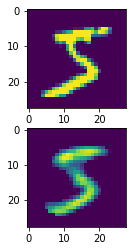

In [449]:
idx = 0
fig, axs = plt.subplots(nrows = 2)
axs[0].imshow(A[idx].reshape(28, 28))
K = skorch_model.module_(torch.tensor(A[idx], device = device))[0].reshape(28, 28).detach().cpu().numpy()
axs[1].imshow(K)

In [432]:
N = torch.distributions.Normal(0, 1)

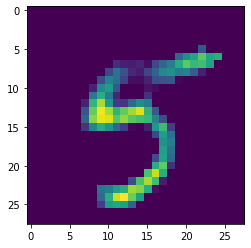

In [452]:
z = N.sample(sample_shape = (1, 600)).cuda()
S = skorch_model.module_.Decoder(z)[0].reshape(28, 28).detach().cpu().numpy()
plt.imshow(S)